# Particle Filter with JAX

**Martin Lysy, University of Waterloo**

**November 11, 2021**

## Summary

The goal is to provide a fast implementation of a particle filter to estimate the marginal likelihood of a state-space model,
$$
\begin{aligned}
\mathcal{L}(\theta) & = p(y_{0:T} \mid \theta) \\
& = \int \prod_{t=0}^T p(y_t \mid x_t, \theta) \times \prod_{t=1}^T p(x_t \mid x_{t-1}, \theta) \times p(x_0 \mid \theta)\, d x_{0:T},   
\end{aligned}
$$
along with its gradient, $\nabla \mathcal{L}(\theta) = \frac{\partial}{\partial \theta} \mathcal{L}(\theta)$.  The [**JAX**](https://github.com/google/jax) library is used to efficiently compose jit and autodiff operations  in order to achieve this.

## Notation

### Functions

- `state_lpdf(x_curr, x_last, theta)`: Log-density of $p(x_t | x_{t-1}, \theta)$.
- `state_sample(x_last, theta)`: Sample from $p(x_t | x_{t-1}, \theta)$.
- `meas_lpdf(y_curr, x_curr, theta)`: Log-density of $p(y_t | x_t, \theta)$.
- `meas_sample(x_curr, theta)`: Sample from $p(y_t | x_t, \theta)$.

### Dimensions

- `n_obs`: Number of time points.
- `n_particle`: Number of particles.
- `n_state`: Tuple of state dimensions.
- `n_meas`: Tuple of measured dimensions.

## TODO

- [ ] Test against true BM likelihood.

- [x] Data should be $y_{0:T}$ instead of $y_{1:T}$.  This has been changed in some of the documentation but not all of it...

- [x] Add arbitrary prior specification $p(x_0 \mid \theta)$.  Should also be able to specify $x_0$ directly to calculate the marginal likelihood $\mathcal{L}(x_0, \theta) = p(y_{0:T} \mid x_0, \theta)$.

- [ ] Example where `n_state` and `n_meas` are not scalar.  This can be SDE with `n_res > 1`.

- [ ] Interface for supplying new models to generic PF code.  Specifically, if we have `import pfjax as pfj` then we may need to JIT something like 

    ```python
    def my_pf(theta):
        out = pfj.particle_filter(y_meas, theta, n_particles,
                                  my_state_sample, my_meas_lpdf,
                                  *args, **kwargs)
        return pfj.particle_loglik(out)
    ```
    
    Or, perhaps instead we can create a `my_pf` object and then `jax.jit(my_pf.loglik)(theta)`?
    
- [ ] Add arbitrary proposal distribution $q(x_t \mid x_{t-1}, \theta)$.  This should perhaps be done using:

    ```python
    step_sample(x_prev, t, theta)
    step_logw(x_curr, x_prev, t, theta)
    ```
    
    instead of e.g., `state_prop_lpdf()`, `state_targ_lpdf()` and `meas_lpdf()` which gets assembled internally for the user.  This is what was done in [**SMCTC**](https://warwick.ac.uk/fac/sci/statistics/staff/academic-research/johansen/smctc/).  But what are the right args to these functions?  Sort of depends if they know about the "global" `y_meas`...

## Example: Brownian motion with drift

The model is
$$
\newcommand{\N}{\mathcal{N}}
\newcommand{\dt}{\Delta t}
\begin{aligned}
x_0 & \sim \pi(x_0) \\
x_t & \sim \N(x_{t-1} + \mu \dt, \sigma^2 \dt) \\
y_t & \sim \N(x_t, \tau^2).
\end{aligned}
$$

Therefore, `n_state` = `n_meas` = 1, and we have a "global" constant $\dt$ through which we never need to take derivatives.  

Note that with $\pi(x_0) \propto 1$, we may condition on $y_0$ and obtain $x_0 \mid y_0 \sim \N(y_0, \tau^2)$.

### Using JAX

**FIXME:** Since the relationship between JAX functions and how to jit them is a bit tricky (e.g., not clear whether/how `import` allows its functions to see others), for now we just load code files via `%run -i`, which is essentially equivalent to copy-pasting contents into notebook.  This will need to be changed as API becomes more usable.  

In [1]:
%run -i bm_model_jax.py
%run -i particle_filter_jax.py
%run -i test_particle_filter_jax.py

[5.  1.  0.1]
y_meas = 
 [[0.        ]
 [0.44947725]
 [0.68188113]
 [0.91331539]
 [1.05404084]]
x_init = 
 [0.]
x_state = 
 [[0.        ]
 [0.4394778 ]
 [0.60337457]
 [0.88978651]
 [1.07383932]]
pf_out = 
 {'X_particles': DeviceArray([[[-6.21298687e-02],
              [-2.09634208e-02],
              [-1.16327993e-03],
              [ 3.70711288e-02],
              [ 2.35676415e-01],
              [-1.67398051e-02],
              [ 1.25699265e-01]],

             [[ 8.37142026e-01],
              [ 9.73443256e-01],
              [ 8.91045447e-01],
              [ 5.95458532e-01],
              [ 3.83360708e-01],
              [ 3.14860129e-01],
              [-1.24713054e-01]],

             [[ 7.35164544e-01],
              [ 8.06331465e-01],
              [ 1.03909144e+00],
              [ 1.87868510e-01],
              [ 5.27870316e-01],
              [ 1.06167049e+00],
              [ 1.28384786e+00]],

             [[ 1.06812160e+00],
              [ 1.16315768e+00],
             

In [3]:
%timeit particle_filter(y_meas, theta, n_particles, subkey)

107 ms ± 8.98 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [4]:
%timeit particle_filter_jitted(y_meas, theta, n_particles, subkey)

42.8 µs ± 2.6 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### Test against exact likelihood

The exact likelihood is defined as $p(y_{1:T} \mid y_0, \theta)$ rather than $p(y_{0:T} \mid \theta)$.  The reason is that the latter expression requires one to integrate over $x_0 \sim \pi(x_0)$, which can only be done when $\pi(x_0)$ is a proper prior.  However, for our choice of $\pi(x_0) \propto 1$ this is not the case.  On the other hand, $p(y_{1:T} \mid y_0, \theta)$ only requires us to integrate over $p(x_0 \mid y_0, \theta)$, which only requires the posterior to be proper (which is always the case for valid Bayesian inference).

Conditioned on $x_0$ and $\theta$, the Brownian latent variables $x_{1:T}$ are multivariate normal with
$$
\newcommand{\cov}{\operatorname{cov}}
\begin{aligned}
%E[x_0 \mid \theta] & = y_0 & \var(x_0\\
E[x_t \mid x_0, \theta] & = x_0 + \mu t, \\
\cov(x_s, x_t \mid x_0, \theta) & = \sigma^2 \min(s, t).
\end{aligned}
$$
Conditioned on $x_{0:T}$ and $\theta$, the measurement variables $y_{1:T}$ are multivariate normal with
$$
\begin{aligned}
E[y_t \mid x_{0:T}, \theta] & = x_{1:T}, \\
\cov(y_s, y_t \mid x_{0:T}, \theta) & = \tau^2 \delta_{st}.
\end{aligned}
$$
Therefore, the marginal distribution of $y_{1:T}$ is multivariate normal with
$$
\begin{aligned}
E[y_t \mid x_0, \theta] & = x_0 + \mu t, \\
\cov(y_s, y_t \mid x_0, \theta) & = \sigma^2 \min(s, t) + \tau^2 \delta_{st}.
\end{aligned}
$$
For the given choice of prior, we have $x_0 \mid y_0 \sim \N(y_0, \tau^2)$ for the initial observation $y_0$.  Integrating over $x_0$, the marginal distribution of $y_{1:T}$ is MVN with
$$
\begin{aligned}
E[y_t \mid y_0, \theta] & = y_0 + \mu t, \\
\cov(y_s, y_t \mid y_0, \theta) & = \sigma^2 \min(s, t) + \tau^2(\delta_{st} + 1).
\end{aligned}
$$

In [2]:
import numpy as np


@jax.jit
def bm_loglik(y_meas, dt, theta):
    """
    Exact loglikelihood of the BM model.
    """
    mu = theta[0]
    sigma2 = theta[1] * theta[1]
    tau2 = theta[2] * theta[2]
    n_obs = y_meas.shape[0]-1  # conditioning on y_0
    t_meas = jnp.arange(1, n_obs+1) * dt
    Sigma_y = sigma2 * jax.vmap(lambda t: jnp.minimum(t, t_meas))(t_meas) + \
        tau2 * (jnp.ones((n_obs, n_obs)) + jnp.eye(n_obs))
    mu_y = y_meas[0] + mu * t_meas
    return jsp.stats.multivariate_normal.logpdf(jnp.squeeze(y_meas[1:]), mu_y, Sigma_y)


bm_loglik(y_meas[0:5], dt, np.array([5, 1.2, 0]))

DeviceArray(-0.75600208, dtype=float64)

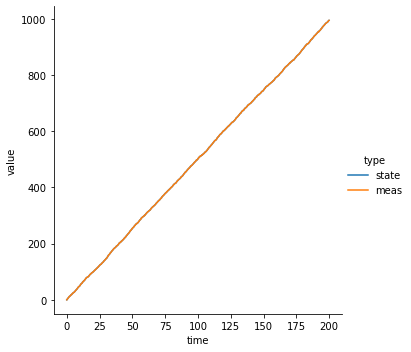

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from proj_data import proj_data

# Simulate some data
key = random.PRNGKey(1)

# parameter values
mu = 5.
sigma = 1.
tau = 0
theta = np.array([mu, sigma, tau])
# data specification
dt = .2
n_obs = 1000
x_init = jnp.array([0.])

# simulate data
key, subkey = random.split(key)
y_meas, x_state = meas_sim(n_obs, x_init, theta, subkey)

# plot data
plot_df = (pd.DataFrame({"time": jnp.arange(n_obs) * dt,
                         "state": jnp.squeeze(x_state),
                         "meas": jnp.squeeze(y_meas)})
           .melt(id_vars="time", var_name="type"))
sns.relplot(
    data=plot_df, kind="line",
    x="time", y="value", hue="type"
)

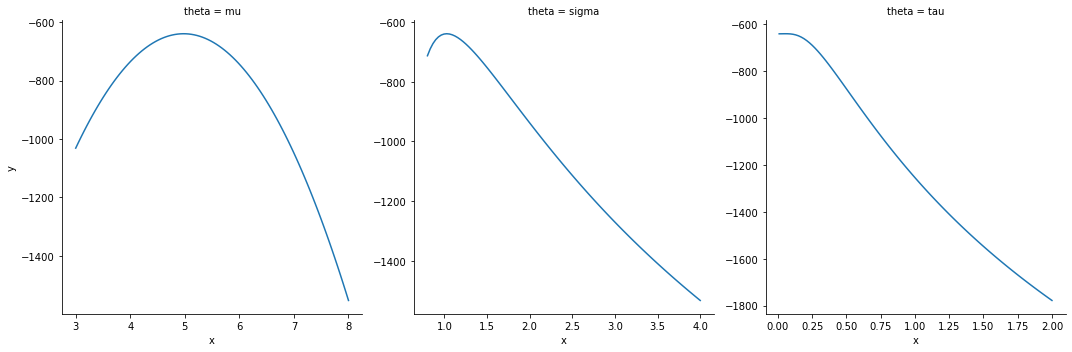

In [4]:
# plot exact likelihood
theta_lims = np.array([[3., 8.], [.8, 4], [.01, 2]])
theta_names = ["mu", "sigma", "tau"]
n_pts = 100

# calculate projection plot
plot_df = proj_data(lambda th: bm_loglik(y_meas, dt, th),
                    theta, theta_lims, theta_names)

sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", col="theta",
    facet_kws=dict(sharex=False, sharey=False)
)

In [ ]:
# for tau = 0, MLE of mu and sigma are analytically available
mu_hat = jnp.mean(jnp.diff(jnp.squeeze(y_meas)))/dt
sigma_hat = jnp.sqrt(jnp.mean((jnp.diff(jnp.squeeze(y_meas)) - mu*dt)**2)/dt)
sigma_hat2 = jnp.std(jnp.diff(jnp.squeeze(y_meas))) / np.sqrt(dt)
print("mu_hat = ", mu_hat)
print("sigma_hat = ", sigma_hat)
print("sigma_hat2 = ", sigma_hat2)
print("theta = ", theta)
# bm_loglik(y_meas, dt, np.array([mu, sigma, tau]))

## Scratch

In [6]:
# Output .py file with jupyter highlighting
from pygments import highlight
from pygments.lexers import PythonLexer
from pygments.formatters import HtmlFormatter
import IPython

with open('particle_filter_jax.py') as f:
    code = f.read()

formatter = HtmlFormatter()
IPython.display.HTML('<style type="text/css">{}</style>{}'.format(
    formatter.get_style_defs('.highlight'),
    highlight(code, PythonLexer(), formatter)))

In [ ]:
plot_df = (pd.DataFrame(np.concatenate((plot_data[0], plot_data[1])).T,
                        columns=[a+b for b in map(str, ["_x", "_y"]) for a in theta_names])
           .melt()
           )
plot_df[["theta", "axis"]] = plot_df["variable"].str.split("_", 1, expand=True)
plot_df = plot_df[["axis", "theta", "value"]]
# plot_df
plot_df.pivot(columns="axis", values=["theta", "value"])
# df = pd.DataFrame({'foo': ['one', 'one', 'one', 'two', 'two',
#                           'two'],
#                   'bar': ['A', 'B', 'C', 'A', 'B', 'C'],
#                   'baz': [1, 2, 3, 4, 5, 6],
#                   'zoo': ['x', 'y', 'z', 'q', 'w', 't']})
# df
#df.pivot(index='foo', columns='bar', values='baz')

In [ ]:
pd.DataFrame(
    jnp.array([[4, 7, 10],
               [5, 8, 11],
               [6, 9, 12]]),
    #index=[1, 2, 3],
    columns=['a', 'b', 'c'])

In [29]:
# check how smooth random.choice is

key = random.PRNGKey(2)


def fun(p):
    """
    Sample one draw from a Bernoulli with probability `p`.
    """
    return random.choice(key, a=jnp.arange(2), p=jnp.array([p, 1-p]))


# see how output varies as we keep the seed fixed but let p range between 0 and 1
n = 100
prob = jnp.linspace(0, 1, n)
x = jnp.zeros(n)
for i in range(n):
    x = x.at[i].set(fun(prob[i]))

# result: sampler is indeed smooth in p.
x

DeviceArray([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float64)